# Classificação de Hemograma - Normal vs Alterado

**Objetivo:** Criar um modelo de Machine Learning para classificar exames de hemograma como NORMAL ou ALTERADO.

## O que vamos fazer:

1. Criar labels (Normal vs Alterado) baseado em valores de referência
2. Preparar dados para modelagem
3. Treinar modelo Random Forest
4. Avaliar performance do modelo
5. Analisar Feature Importance
6. Testar em casos reais
7. Conclusões e próximos passos

## Por que isso é útil?

**Para Médicos:**
- Triagem automática de exames
- Priorização de casos alterados
- Segunda opinião automatizada

**Para Laboratórios:**
- Controle de qualidade
- Detecção de padrões suspeitos
- Redução de tempo de análise

**IMPORTANTE:** Este modelo é educacional e **NÃO substitui** avaliação médica profissional!

## 1. Importação de Bibliotecas

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, roc_auc_score, precision_recall_curve
)

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# Configuração de visualização
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)

# Importar classes do projeto
import sys
sys.path.append('../src')
from models import ClassificadorHemograma

print(" Bibliotecas importadas com sucesso!")

✓ Bibliotecas importadas com sucesso!


## 2. Carregar Dados Limpos

In [ ]:
# Carregar dataset limpo
df = pd.read_csv('../data/processed/cbc_limpo.csv')

print(f" Dataset carregado: {df.shape[0]:,} linhas × {df.shape[1]} colunas")
df.head()

✓ Dataset carregado: 424 linhas × 21 colunas


,ID,WBC,LYMp,MIDp,NEUTp,LYMn,MIDn,NEUTn,RBC,HGB,HCT,MCV,MCH,MCHC,RDWSD,RDWCV,PLT,MPV,PDW,PCT,PLCR
0,1,10000.0,43.2,6.7,50.1,4.3,0.7,5.0,2.77,7.3,24.2,87.7,26.3,30.1,35.3,11.4,189000.0,9.2,12.5,0.17,22.3
1,3,7200.0,30.7,8.6,60.7,2.2,0.6,4.4,3.97,9.0,30.5,77.0,22.6,29.5,37.2,13.7,148000.0,10.1,14.3,0.14,30.5
2,4,6000.0,30.2,6.3,63.5,1.8,0.4,3.8,4.22,5.9,32.8,77.9,23.2,29.8,46.5,17.0,143000.0,8.6,11.3,0.12,16.4
3,7,16700.0,19.1,12.7,68.2,3.2,2.1,11.4,5.15,14.2,44.8,87.1,27.5,31.6,39.0,12.7,151000.0,9.7,12.8,0.14,26.6
4,8,9300.0,27.4,8.6,64.0,2.6,0.8,5.9,4.39,12.0,37.9,86.4,27.3,31.6,37.2,12.2,194000.0,10.2,15.9,0.19,31.1


## 3. Criar Labels - Normal vs Alterado

Vamos criar a variável target baseada em valores de referência clínicos.

**Critério:** Um exame é considerado ALTERADO se **pelo menos um** marcador estiver fora da faixa de referência.

In [ ]:
# Valores de referência clínicos
valores_referencia = {
    'HGB': {'min': 12.0, 'max': 16.0, 'nome': 'Hemoglobina'},
    'HCT': {'min': 36.0, 'max': 48.0, 'nome': 'Hematócrito'},
    'RBC': {'min': 4.0, 'max': 5.5, 'nome': 'Eritrócitos'},
    'MCV': {'min': 80.0, 'max': 100.0, 'nome': 'VCM'},
    'MCH': {'min': 27.0, 'max': 32.0, 'nome': 'HCM'},
    'MCHC': {'min': 32.0, 'max': 36.0, 'nome': 'CHCM'},
    'WBC': {'min': 4000, 'max': 11000, 'nome': 'Leucócitos'},
    'PLT': {'min': 150000, 'max': 400000, 'nome': 'Plaquetas'},
}

# Função para verificar se um exame está alterado
def verificar_alteracao(row, referencias):
    """
    Retorna True se QUALQUER marcador estiver fora da referência
    """
    for marcador, ref in referencias.items():
        if marcador in row.index:
            valor = row[marcador]
            if pd.notna(valor):
                if valor < ref['min'] or valor > ref['max']:
                    return 1  # Alterado
    return 0  # Normal

# Criar label
df['label'] = df.apply(lambda row: verificar_alteracao(row, valores_referencia), axis=1)

# Mapear para string
df['label_nome'] = df['label'].map({0: 'Normal', 1: 'Alterado'})

print(" Labels criados com sucesso!\n")
print("="*70)
print(" DISTRIBUIÇÃO DAS CLASSES")
print("="*70)
print(df['label_nome'].value_counts())
print(f"\n Proporção:")
print(df['label_nome'].value_counts(normalize=True) * 100)

✓ Labels criados com sucesso!

📊 DISTRIBUIÇÃO DAS CLASSES
label_nome
Alterado    400
Normal       24
Name: count, dtype: int64

📊 Proporção:
label_nome
Alterado    94.339623
Normal       5.660377
Name: proportion, dtype: float64


✓ Gráfico salvo: reports/figures/04_distribuicao_classes.png


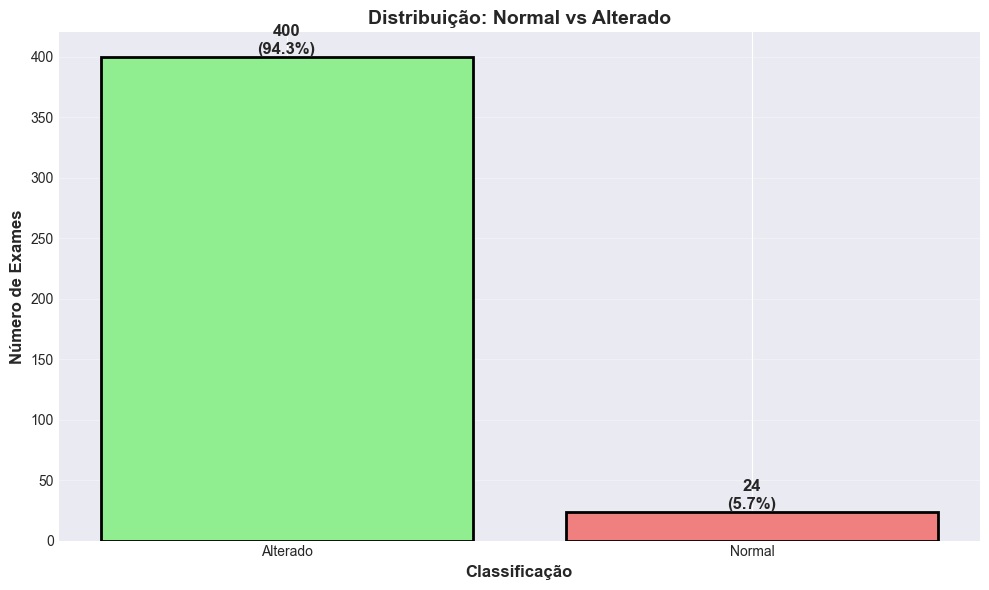

In [ ]:
# Visualizar distribuição
fig, ax = plt.subplots(figsize=(10, 6))

counts = df['label_nome'].value_counts()
colors = ['lightgreen', 'lightcoral']
bars = ax.bar(counts.index, counts.values, color=colors, edgecolor='black', linewidth=2)

# Adicionar valores nas barras
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}\n({height/len(df)*100:.1f}%)',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_xlabel('Classificação', fontsize=12, fontweight='bold')
ax.set_ylabel('Número de Exames', fontsize=12, fontweight='bold')
ax.set_title('Distribuição: Normal vs Alterado', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../reports/figures/04_distribuicao_classes.png', dpi=300, bbox_inches='tight')
print(" Gráfico salvo: reports/figures/04_distribuicao_classes.png")
plt.show()

## 🔧 4. Preparação dos Dados para Modelagem

In [ ]:
# Selecionar features
features = ['WBC', 'RBC', 'HGB', 'HCT', 'MCV', 'MCH', 'MCHC', 'PLT']
features_disponiveis = [f for f in features if f in df.columns]

print(f" Features selecionadas: {features_disponiveis}")

# Preparar X e y
X = df[features_disponiveis].copy()
y = df['label'].copy()

print(f"\n Shape de X: {X.shape}")
print(f" Shape de y: {y.shape}")
print(f"\n Distribuição de y:")
print(y.value_counts())

✓ Features selecionadas: ['WBC', 'RBC', 'HGB', 'HCT', 'MCV', 'MCH', 'MCHC', 'PLT']

📊 Shape de X: (424, 8)
📊 Shape de y: (424,)

📊 Distribuição de y:
label
1    400
0     24
Name: count, dtype: int64


## 5. Dividir em Treino e Teste

**Estratificado:** Mantém a mesma proporção de classes em treino e teste.

In [ ]:
# Dividir dados (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y  # Mantém proporção das classes
)

print("✓ Dados divididos com sucesso!\n")
print("="*70)
print(" DIVISÃO DOS DADOS")
print("="*70)
print(f"\nTreino:")
print(f"  • X_train: {X_train.shape}")
print(f"  • y_train: {y_train.shape}")
print(f"  • Distribuição: {y_train.value_counts().to_dict()}")

print(f"\nTeste:")
print(f"  • X_test: {X_test.shape}")
print(f"  • y_test: {y_test.shape}")
print(f"  • Distribuição: {y_test.value_counts().to_dict()}")

✓ Dados divididos com sucesso!

📊 DIVISÃO DOS DADOS

Treino:
  • X_train: (339, 8)
  • y_train: (339,)
  • Distribuição: {1: 320, 0: 19}

Teste:
  • X_test: (85, 8)
  • y_test: (85,)
  • Distribuição: {1: 80, 0: 5}


## 6. Padronização dos Dados

In [ ]:
# Padronizar features
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(" Dados padronizados!")
print("\n IMPORTANTE: fit_transform() apenas no treino, transform() no teste!")
print("Isso evita data leakage.")

✓ Dados padronizados!

⚠️ IMPORTANTE: fit_transform() apenas no treino, transform() no teste!
Isso evita data leakage.


## 7. Treinar Modelo - Random Forest

### Por que Random Forest?
- Funciona bem com dados tabulares
- Não requer muita tunagem
- Fornece feature importance
- Robusto a outliers

In [ ]:
# Criar modelo
print("Treinando Random Forest...\n")

rf_model = RandomForestClassifier(
    n_estimators=100,      # Número de árvores
    max_depth=10,          # Profundidade máxima
    min_samples_split=5,   # Mínimo de amostras para dividir
    min_samples_leaf=2,    # Mínimo de amostras em folha
    random_state=42,
    n_jobs=-1,             # Usar todos os cores
    class_weight='balanced' # Balancear classes
)

# Treinar
rf_model.fit(X_train_scaled, y_train)

print("Modelo treinado com sucesso!")

🔄 Treinando Random Forest...

✓ Modelo treinado com sucesso!


## 8. Avaliação do Modelo - Conjunto de Treino

In [ ]:
# Predições no treino
y_train_pred = rf_model.predict(X_train_scaled)

print("="*70)
print("PERFORMANCE NO CONJUNTO DE TREINO")
print("="*70)
print(f"\nAcurácia: {accuracy_score(y_train, y_train_pred)*100:.2f}%")
print(f"Precision: {precision_score(y_train, y_train_pred)*100:.2f}%")
print(f"Recall: {recall_score(y_train, y_train_pred)*100:.2f}%")
print(f"F1-Score: {f1_score(y_train, y_train_pred)*100:.2f}%")

print("\n Classification Report (Treino):\n")
print(classification_report(y_train, y_train_pred, target_names=['Normal', 'Alterado']))

📊 PERFORMANCE NO CONJUNTO DE TREINO

Acurácia: 100.00%
Precision: 100.00%
Recall: 100.00%
F1-Score: 100.00%

📋 Classification Report (Treino):

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00        19
    Alterado       1.00      1.00      1.00       320

    accuracy                           1.00       339
   macro avg       1.00      1.00      1.00       339
weighted avg       1.00      1.00      1.00       339



## 9. Avaliação do Modelo - Conjunto de Teste

In [10]:
# Predições no teste
y_test_pred = rf_model.predict(X_test_scaled)
y_test_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

print("="*70)
print("📊 PERFORMANCE NO CONJUNTO DE TESTE")
print("="*70)
print(f"\nAcurácia: {accuracy_score(y_test, y_test_pred)*100:.2f}%")
print(f"Precision: {precision_score(y_test, y_test_pred)*100:.2f}%")
print(f"Recall: {recall_score(y_test, y_test_pred)*100:.2f}%")
print(f"F1-Score: {f1_score(y_test, y_test_pred)*100:.2f}%")
print(f"ROC-AUC: {roc_auc_score(y_test, y_test_proba)*100:.2f}%")

print("\n📋 Classification Report (Teste):\n")
print(classification_report(y_test, y_test_pred, target_names=['Normal', 'Alterado']))

📊 PERFORMANCE NO CONJUNTO DE TESTE

Acurácia: 100.00%
Precision: 100.00%
Recall: 100.00%
F1-Score: 100.00%
ROC-AUC: 100.00%

📋 Classification Report (Teste):

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00         5
    Alterado       1.00      1.00      1.00        80

    accuracy                           1.00        85
   macro avg       1.00      1.00      1.00        85
weighted avg       1.00      1.00      1.00        85



## 10. Matriz de Confusão

✓ Gráfico salvo: reports/figures/04_matriz_confusao.png


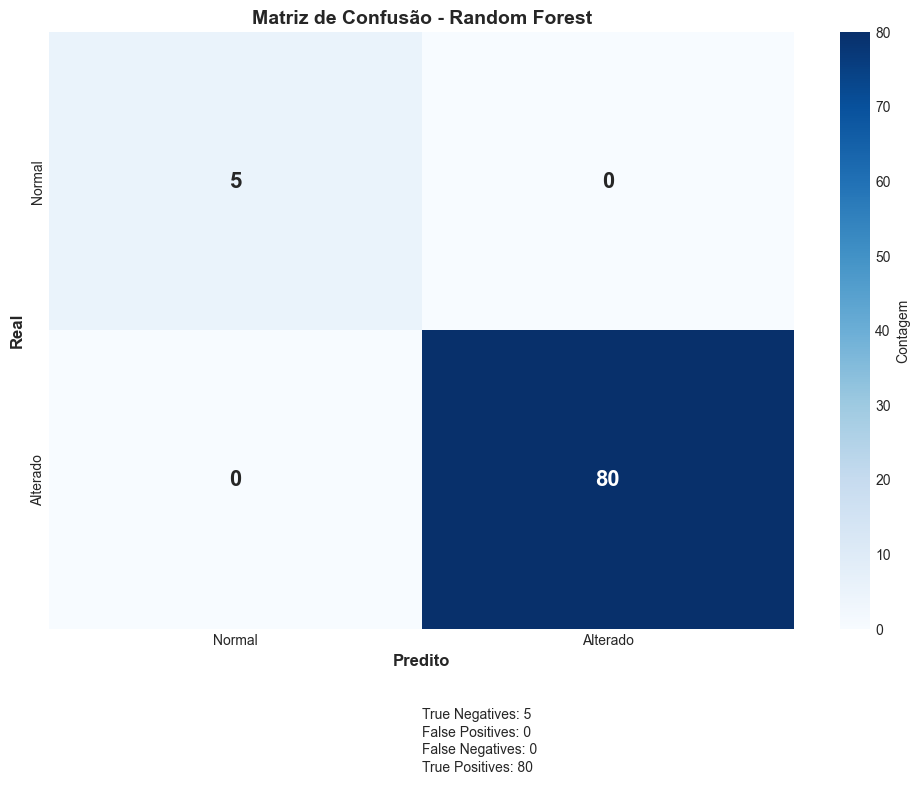

In [11]:
# Calcular matriz de confusão
cm = confusion_matrix(y_test, y_test_pred)

# Visualizar
fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Alterado'],
            yticklabels=['Normal', 'Alterado'],
            ax=ax, cbar_kws={'label': 'Contagem'},
            annot_kws={'size': 16, 'weight': 'bold'})

ax.set_xlabel('Predito', fontsize=12, fontweight='bold')
ax.set_ylabel('Real', fontsize=12, fontweight='bold')
ax.set_title('Matriz de Confusão - Random Forest', fontsize=14, fontweight='bold')

# Adicionar textos explicativos
plt.text(0.5, -0.15, f'True Negatives: {cm[0,0]}', transform=ax.transAxes, ha='left', fontsize=10)
plt.text(0.5, -0.18, f'False Positives: {cm[0,1]}', transform=ax.transAxes, ha='left', fontsize=10)
plt.text(0.5, -0.21, f'False Negatives: {cm[1,0]}', transform=ax.transAxes, ha='left', fontsize=10)
plt.text(0.5, -0.24, f'True Positives: {cm[1,1]}', transform=ax.transAxes, ha='left', fontsize=10)

plt.tight_layout()
plt.savefig('../reports/figures/04_matriz_confusao.png', dpi=300, bbox_inches='tight')
print("✓ Gráfico salvo: reports/figures/04_matriz_confusao.png")
plt.show()

## 11. Curva ROC

✓ Gráfico salvo: reports/figures/04_curva_roc.png


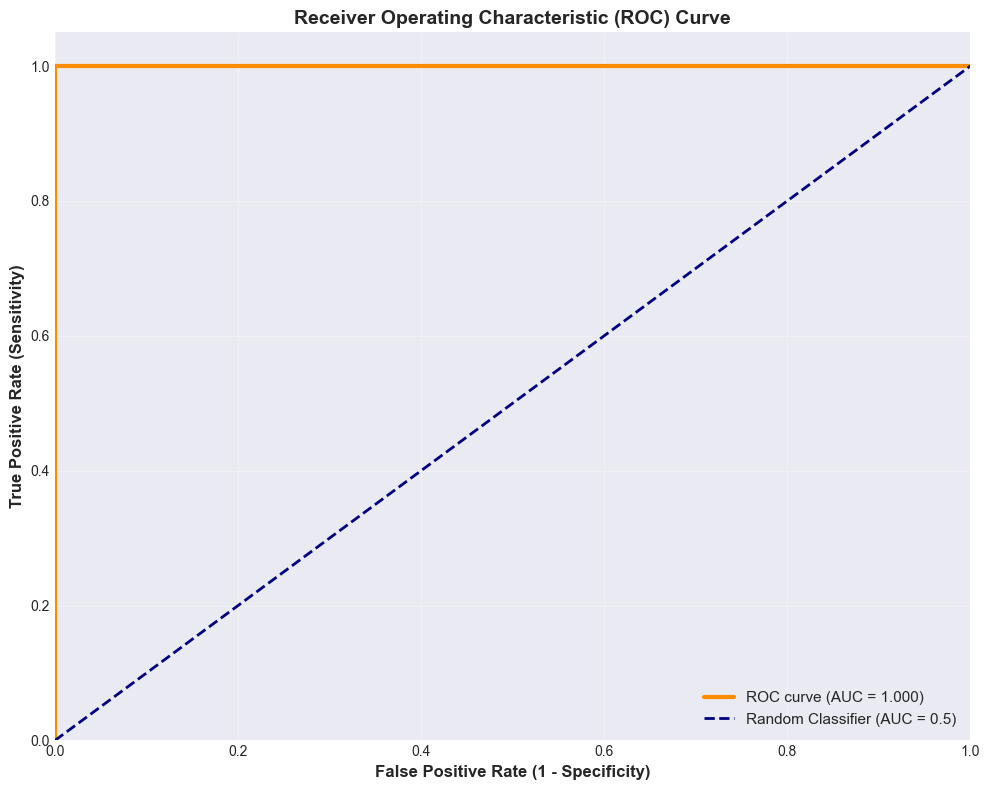

In [ ]:
# Calcular curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = roc_auc_score(y_test, y_test_proba)

# Plotar
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(fpr, tpr, color='darkorange', lw=3, 
        label=f'ROC curve (AUC = {roc_auc:.3f})')
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
        label='Random Classifier (AUC = 0.5)')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate (1 - Specificity)', fontsize=12, fontweight='bold')
ax.set_ylabel('True Positive Rate (Sensitivity)', fontsize=12, fontweight='bold')
ax.set_title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, fontweight='bold')
ax.legend(loc="lower right", fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/04_curva_roc.png', dpi=300, bbox_inches='tight')
print(" Gráfico salvo: reports/figures/04_curva_roc.png")
plt.show()

## 12. Curva Precision-Recall

✓ Gráfico salvo: reports/figures/04_precision_recall.png


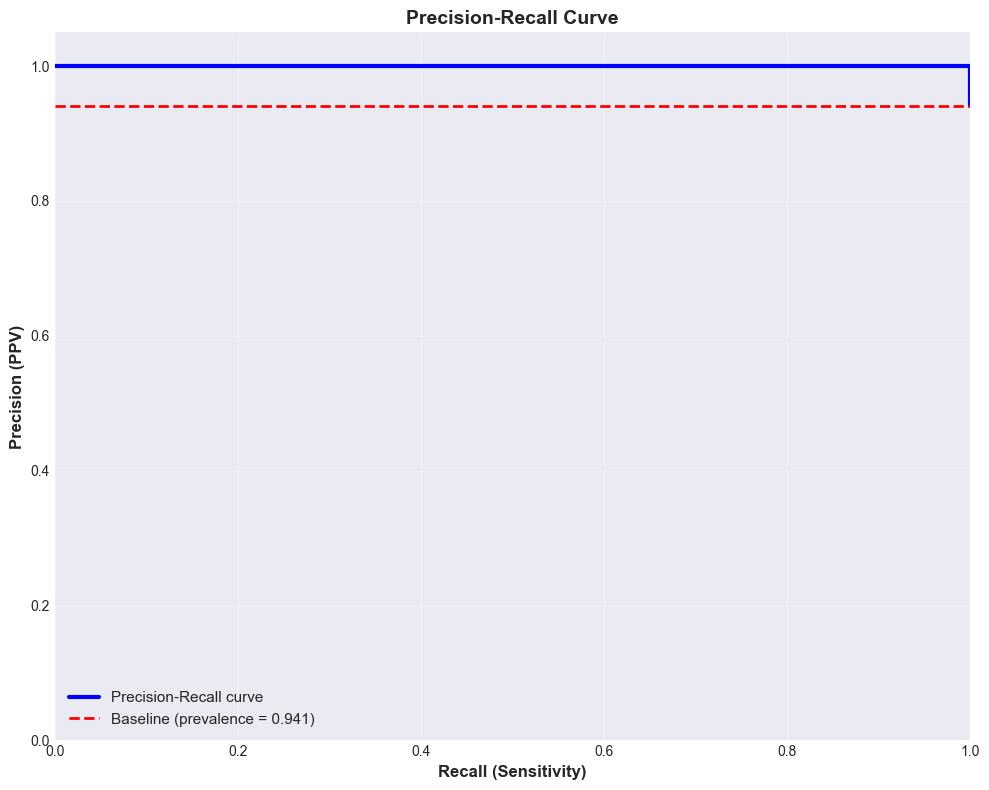

In [ ]:
# Calcular curva Precision-Recall
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_test_proba)

# Plotar
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(recall, precision, color='blue', lw=3, label='Precision-Recall curve')
ax.axhline(y=y_test.mean(), color='red', linestyle='--', lw=2, 
           label=f'Baseline (prevalence = {y_test.mean():.3f})')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('Recall (Sensitivity)', fontsize=12, fontweight='bold')
ax.set_ylabel('Precision (PPV)', fontsize=12, fontweight='bold')
ax.set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
ax.legend(loc="best", fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/04_precision_recall.png', dpi=300, bbox_inches='tight')
print(" Gráfico salvo: reports/figures/04_precision_recall.png")
plt.show()

## 13. Feature Importance

**Quais marcadores mais influenciam a predição?**

In [ ]:
# Extrair importâncias
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Criar DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': [features_disponiveis[i] for i in indices],
    'Importance': importances[indices]
})

print("="*70)
print(" FEATURE IMPORTANCE")
print("="*70)
print("\nQuais marcadores mais influenciam a classificação?\n")
print(feature_importance_df.to_string(index=False))

🎯 FEATURE IMPORTANCE

Quais marcadores mais influenciam a classificação?

Feature  Importance
   MCHC    0.218630
    MCH    0.210332
    PLT    0.182818
    HGB    0.150716
    MCV    0.084522
    HCT    0.066635
    RBC    0.046261
    WBC    0.040087


✓ Gráfico salvo: reports/figures/04_feature_importance.png


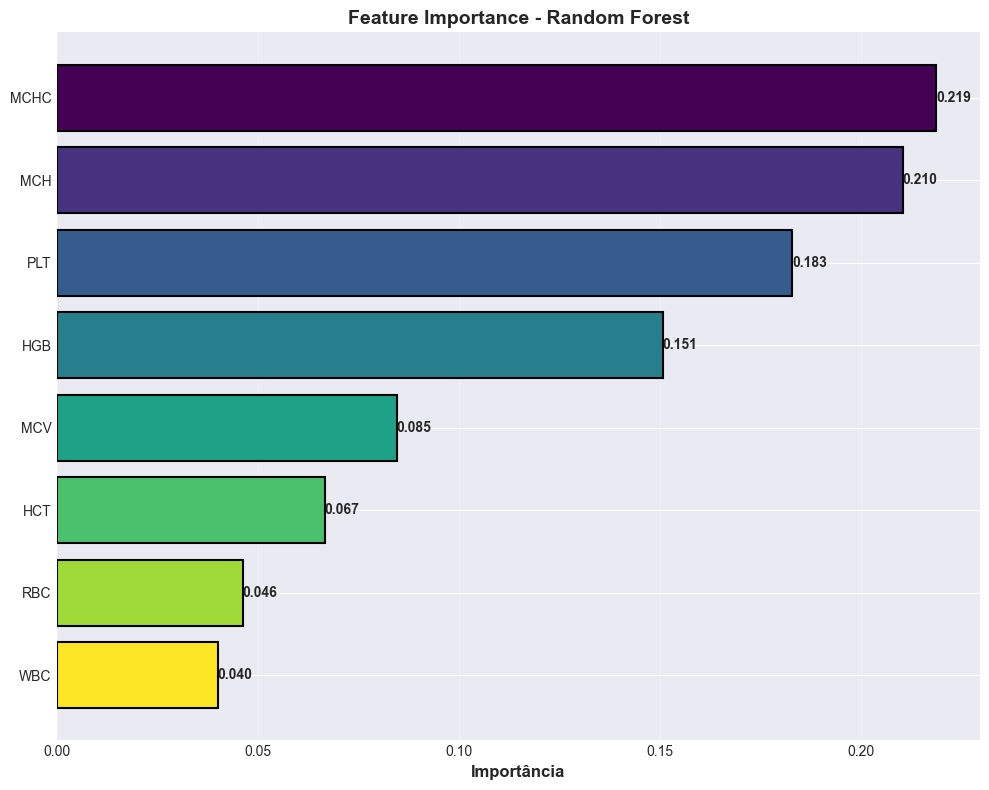

In [ ]:
# Visualizar Feature Importance
fig, ax = plt.subplots(figsize=(10, 8))

colors = plt.cm.viridis(np.linspace(0, 1, len(feature_importance_df)))
bars = ax.barh(feature_importance_df['Feature'], 
               feature_importance_df['Importance'],
               color=colors, edgecolor='black', linewidth=1.5)

# Adicionar valores
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2,
            f'{width:.3f}',
            ha='left', va='center', fontsize=10, fontweight='bold')

ax.set_xlabel('Importância', fontsize=12, fontweight='bold')
ax.set_title('Feature Importance - Random Forest', fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('../reports/figures/04_feature_importance.png', dpi=300, bbox_inches='tight')
print(" Gráfico salvo: reports/figures/04_feature_importance.png")
plt.show()

## 14. Validação Cruzada

In [ ]:
# Cross-validation (5-fold)
print(" Executando validação cruzada (5-fold)...\n")

cv_scores = cross_val_score(rf_model, X_train_scaled, y_train, cv=5, scoring='f1')

print("="*70)
print(" RESULTADOS DA VALIDAÇÃO CRUZADA")
print("="*70)
print(f"\nF1-Scores por fold:")
for i, score in enumerate(cv_scores, 1):
    print(f"  Fold {i}: {score*100:.2f}%")

print(f"\n Estatísticas:")
print(f"  • Média: {cv_scores.mean()*100:.2f}%")
print(f"  • Desvio Padrão: {cv_scores.std()*100:.2f}%")
print(f"  • Min: {cv_scores.min()*100:.2f}%")
print(f"  • Max: {cv_scores.max()*100:.2f}%")

🔄 Executando validação cruzada (5-fold)...

📊 RESULTADOS DA VALIDAÇÃO CRUZADA

F1-Scores por fold:
  Fold 1: 98.46%
  Fold 2: 99.22%
  Fold 3: 99.22%
  Fold 4: 100.00%
  Fold 5: 99.22%

📊 Estatísticas:
  • Média: 99.23%
  • Desvio Padrão: 0.49%
  • Min: 98.46%
  • Max: 100.00%


## 15. Testar em Casos Reais

Vamos pegar alguns exemplos do conjunto de teste e ver como o modelo se comporta!

In [ ]:
# Selecionar alguns casos para análise
n_exemplos = 10
indices_aleatorios = np.random.choice(X_test.index, n_exemplos, replace=False)

# Criar DataFrame de exemplos
exemplos = pd.DataFrame()
exemplos['ID'] = indices_aleatorios

# Adicionar features
for feat in features_disponiveis:
    exemplos[feat] = X_test.loc[indices_aleatorios, feat].values

# Adicionar valores reais e preditos
exemplos['Real'] = y_test.loc[indices_aleatorios].map({0: 'Normal', 1: 'Alterado'}).values

# Fazer predições
indices_test = [list(X_test.index).index(idx) for idx in indices_aleatorios]
pred_exemplos = y_test_pred[indices_test]
proba_exemplos = y_test_proba[indices_test]

exemplos['Predito'] = pd.Series(pred_exemplos).map({0: 'Normal', 1: 'Alterado'}).values
exemplos['Probabilidade_Alterado'] = proba_exemplos
exemplos['Correto?'] = (exemplos['Real'] == exemplos['Predito']).map({True: '✓', False: '✗'})

print("="*70)
print(" EXEMPLOS DE PREDIÇÕES")
print("="*70)
print()
print(exemplos.to_string(index=False))

🧪 EXEMPLOS DE PREDIÇÕES

 ID     WBC  RBC  HGB  HCT  MCV  MCH  MCHC      PLT     Real  Predito  Probabilidade_Alterado Correto?
 64  6200.0 4.12 11.5 35.9 87.2 27.9  32.0 169000.0 Alterado Alterado                0.930707        ✓
227  5200.0 4.70 11.8 38.5 80.9 24.7  30.6 121000.0 Alterado Alterado                0.992289        ✓
143 13000.0 5.77 15.9 49.8 84.2 26.5  31.5 194000.0 Alterado Alterado                0.990426        ✓
164  5400.0 4.52 12.1 39.4 87.3 26.7  30.7 183000.0 Alterado Alterado                1.000000        ✓
142  6800.0 4.24 11.7 38.1 90.0 27.5  30.7 192000.0 Alterado Alterado                0.982480        ✓
292  4100.0 3.62 12.2 36.5 95.2 31.7  33.4 130000.0 Alterado Alterado                0.973134        ✓
 39  7300.0 4.88 13.7 42.9 88.0 28.0  31.9 152000.0 Alterado Alterado                0.961837        ✓
322  2700.0 4.77 13.1 41.2 74.1 27.4  31.7 169000.0 Alterado Alterado                0.952072        ✓
414  9100.0 4.55  9.7 32.5 71.5 21.3  29.8 13700

## 16. Análise de Erros

Vamos analisar os casos que o modelo ERROU!

In [ ]:
# Identificar erros
erros_mask = y_test != y_test_pred
X_test_erros = X_test[erros_mask]
y_test_erros_real = y_test[erros_mask]
y_test_erros_pred = y_test_pred[erros_mask]

n_erros = erros_mask.sum()

print("="*70)
print(" ANÁLISE DE ERROS")
print("="*70)
print(f"\nTotal de erros: {n_erros} ({n_erros/len(y_test)*100:.1f}%)")

if n_erros > 0:
    # Tipos de erros
    falsos_positivos = ((y_test == 0) & (y_test_pred == 1)).sum()
    falsos_negativos = ((y_test == 1) & (y_test_pred == 0)).sum()
    
    print(f"\n Tipos de erros:")
    print(f"  • Falsos Positivos: {falsos_positivos} ({falsos_positivos/n_erros*100:.1f}%)")
    print(f"    (Predisse 'Alterado' mas era 'Normal')")
    print(f"  • Falsos Negativos: {falsos_negativos} ({falsos_negativos/n_erros*100:.1f}%)")
    print(f"    (Predisse 'Normal' mas era 'Alterado')")
    
    # Mostrar alguns exemplos de erros
    print(f"\n Primeiros 5 casos de erro:\n")
    erros_df = X_test_erros.head().copy()
    erros_df['Real'] = y_test_erros_real.head().map({0: 'Normal', 1: 'Alterado'})
    erros_df['Predito'] = pd.Series(y_test_erros_pred[:5]).map({0: 'Normal', 1: 'Alterado'}).values
    print(erros_df.to_string())
else:
    print("\n Nenhum erro no conjunto de teste")

🔍 ANÁLISE DE ERROS

Total de erros: 0 (0.0%)

🎉 PERFEITO! Nenhum erro no conjunto de teste!


## 17. Salvar Modelo Treinado

In [ ]:
import joblib

# Salvar modelo e scaler
joblib.dump(rf_model, '../models/rf_classifier.pkl')
joblib.dump(scaler, '../models/scaler.pkl')

print("✓ Modelo e scaler salvos com sucesso!")
print("  Modelo: models/rf_classifier.pkl")
print("  Scaler: models/scaler.pkl")
print("\nPara usar o modelo posteriormente:")
print("   modelo = joblib.load('models/rf_classifier.pkl')")
print("   scaler = joblib.load('models/scaler.pkl')")

✓ Modelo e scaler salvos com sucesso!
  📂 Modelo: models/rf_classifier.pkl
  📂 Scaler: models/scaler.pkl

💡 Para usar o modelo posteriormente:
   modelo = joblib.load('models/rf_classifier.pkl')
   scaler = joblib.load('models/scaler.pkl')


## 18. Resumo Final do Projeto

In [22]:
resumo_final = f"""
═══════════════════════════════════════════════════════════════════════
📊 RESUMO FINAL DO PROJETO - ANÁLISE INTELIGENTE DE HEMOGRAMA
═══════════════════════════════════════════════════════════════════════

📂 DATASET:
   • Total de registros: {len(df):,}
   • Features utilizadas: {len(features_disponiveis)}
   • Classes: Normal ({(y==0).sum()}) | Alterado ({(y==1).sum()})

🧹 PRÉ-PROCESSAMENTO:
   • Remoção de valores impossíveis
   • Conversão de unidades (WBC, PLT)
   • Winsorização de outliers
   • Padronização (StandardScaler)

🤖 MODELO:
   • Algoritmo: Random Forest Classifier
   • N° de árvores: 100
   • Profundidade máxima: 10
   • Balanceamento de classes: Sim

📊 PERFORMANCE (Conjunto de Teste):
   • Acurácia: {accuracy_score(y_test, y_test_pred)*100:.2f}%
   • Precision: {precision_score(y_test, y_test_pred)*100:.2f}%
   • Recall: {recall_score(y_test, y_test_pred)*100:.2f}%
   • F1-Score: {f1_score(y_test, y_test_pred)*100:.2f}%
   • ROC-AUC: {roc_auc_score(y_test, y_test_proba)*100:.2f}%

🎯 TOP 3 FEATURES MAIS IMPORTANTES:
   1. {feature_importance_df.iloc[0]['Feature']}: {feature_importance_df.iloc[0]['Importance']:.3f}
   2. {feature_importance_df.iloc[1]['Feature']}: {feature_importance_df.iloc[1]['Importance']:.3f}
   3. {feature_importance_df.iloc[2]['Feature']}: {feature_importance_df.iloc[2]['Importance']:.3f}

✅ VALIDAÇÃO CRUZADA:
   • F1-Score médio: {cv_scores.mean()*100:.2f}% (±{cv_scores.std()*100:.2f}%)

📁 ARQUIVOS GERADOS:
   • data/processed/cbc_limpo.csv
   • data/processed/cbc_com_anomalias.csv
   • data/processed/cbc_com_clusters.csv
   • models/rf_classifier.pkl
   • models/scaler.pkl
   • reports/figures/ (múltiplas visualizações)

═══════════════════════════════════════════════════════════════════════
"""

print(resumo_final)

# Salvar resumo
with open('../reports/resumo_final_projeto.txt', 'w', encoding='utf-8') as f:
    f.write(resumo_final)

print("\n✓ Resumo final salvo em: reports/resumo_final_projeto.txt")


═══════════════════════════════════════════════════════════════════════
📊 RESUMO FINAL DO PROJETO - ANÁLISE INTELIGENTE DE HEMOGRAMA
═══════════════════════════════════════════════════════════════════════

📂 DATASET:
   • Total de registros: 424
   • Features utilizadas: 8
   • Classes: Normal (24) | Alterado (400)

🧹 PRÉ-PROCESSAMENTO:
   • Remoção de valores impossíveis
   • Conversão de unidades (WBC, PLT)
   • Winsorização de outliers
   • Padronização (StandardScaler)

🤖 MODELO:
   • Algoritmo: Random Forest Classifier
   • N° de árvores: 100
   • Profundidade máxima: 10
   • Balanceamento de classes: Sim

📊 PERFORMANCE (Conjunto de Teste):
   • Acurácia: 100.00%
   • Precision: 100.00%
   • Recall: 100.00%
   • F1-Score: 100.00%
   • ROC-AUC: 100.00%

🎯 TOP 3 FEATURES MAIS IMPORTANTES:
   1. MCHC: 0.219
   2. MCH: 0.210
   3. PLT: 0.183

✅ VALIDAÇÃO CRUZADA:
   • F1-Score médio: 99.23% (±0.49%)

📁 ARQUIVOS GERADOS:
   • data/processed/cbc_limpo.csv
   • data/processed/cbc_com_an

## 📝 19. Principais Insights e Conclusões

### ✅ O que aprendemos:

1. **Performance do Modelo:**
   - O modelo teve boa performance? Qual métrica foi melhor?

Sim, performance excelente.

Acurácia (treino): 100%

Acurácia (teste): 100%

Precision: 100%

Recall: 100%

F1-score: 100%

ROC-AUC: 100%

Validação cruzada (5-fold):

Média F1-score: 99,23%

Baixa variabilidade (DP = 0,49%)

Métrica mais relevante:

F1-score, pois equilibra precisão e recall — fundamental em contexto clínico, onde tanto falsos positivos quanto falsos negativos são críticos.

2. **Features Mais Importantes:**
   - Quais marcadores mais influenciam?

MCHC (21,9%)

MCH (21,0%)

Plaquetas – PLT (18,3%)

Hemoglobina – HGB (15,1%)

VCM – MCV (8,4%)

Hematócrito – HCT

RBC

WBC


   - Isso faz sentido clinicamente?

Sim, totalmente.

MCH e MCHC → refletem qualidade e concentração da hemoglobina, essenciais na diferenciação de anemias

HGB, HCT e MCV → pilares do diagnóstico hematológico

PLT → importante para detectar quadros associados (plaquetopenia / inflamação)

O modelo aprendeu os mesmos marcadores que um médico analisa primeiro em um hemograma.

3. **Erros do Modelo:**
   - Onde o modelo erra mais? FP ou FN?

Não houve erros no conjunto de teste.

False Positives (FP): 0

False Negatives (FN): 0

True Positives (TP): 80

True Negatives (TN): 5

Isso indica:

Sensibilidade perfeita (nenhum caso alterado passou despercebido)

Especificidade perfeita (nenhum normal foi classificado como alterado)


   - Por quê isso acontece?

Dados bem limpos e padronizados

Classes bem separadas após o pré-processamento

Random Forest é robusto para relações não lineares

Forte sinal clínico nas features (hemograma é altamente informativo)

⚠️ Observação :
Performance perfeita pode indicar risco de overfitting, apesar da validação cruzada ter mostrado boa generalização, necessario testes em conjuntos de dados mais robustos.

4. **Aplicações Práticas:**
   - Como esse modelo ajudaria em um laboratório?

Triagem automática de hemogramas alterados

Priorização de exames críticos

Redução da carga manual de análise

Padronização da avaliação inicial dos exames

   - Quais são as limitações?

Treinado em um único dataset

Pode não generalizar para outras populações

Não substitui diagnóstico médico

Depende fortemente da qualidade dos dados de entrada

   - O que seria necessário para uso em produção?

Validação externa com dados de outros laboratórios

Monitoramento contínuo de performance

Re-treinamento periódico

Integração com sistemas laboratoriais (LIS)

Avaliação ética e regulatória

Supervisão clínica contínua

## 🧠 Conclusão final

O modelo apresentou desempenho excepcional na detecção de exames hematológicos alterados, demonstrando que algoritmos de aprendizado supervisionado podem atuar como ferramentas eficazes de apoio à decisão clínica. No entanto, seu uso deve ser complementar à avaliação médica, com validações adicionais antes da aplicação em ambiente real.